<a href="https://colab.research.google.com/github/aritejhg/ESP3201-Instrument-indentification/blob/main/VGGish_baseline_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This colab demonstrates how to extract the AudioSet embeddings, using a VGGish deep neural network (DNN).

It's an updated version of malcolmslaney's original, modified to work with the updated tensorflow/models VGGish distribution, as well as TensorFlow 2.

In [ ]:
# Upgrade pip first. Also make sure wheel is installed.
!pip install --upgrade pip wheel

In [ ]:
# Download original zip
!wget https://zenodo.org/record/1432913/files/openmic-2018-v1.0.0.tgz

--2022-11-03 03:08:48--  https://zenodo.org/record/1432913/files/openmic-2018-v1.0.0.tgz
Resolving zenodo.org (zenodo.org)... 188.184.117.155
Connecting to zenodo.org (zenodo.org)|188.184.117.155|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2623376754 (2.4G) [application/octet-stream]
Saving to: ‘openmic-2018-v1.0.0.tgz’

openmic-2018-v1.0.0 100%[===================>]   2.44G  22.7MB/s    in 2m 10s  

2022-11-03 03:11:00 (19.2 MB/s) - ‘openmic-2018-v1.0.0.tgz’ saved [2623376754/2623376754]



In [ ]:
# no need to copy zip to drive anymore since download is fast
# %cp "/content/openmic-2018-v1.0.0.tgz" "/content/drive/MyDrive/ESP3201/Datasets/openmic-2018-v1.0.0.tgz"

In [ ]:
# Extract and delete the zip
!tar --extract --file /content/openmic-2018-v1.0.0.tgz
!rm /content/openmic-2018-v1.0.0.tgz

In [ ]:
%cd ..

/content


In [ ]:
%cd /content/openmic-2018

/content/openmic-2018


In [ ]:
!pwd

/content/openmic-2018


In [ ]:
# These dependencies are necessary for loading the data
import json
import os
import numpy as np
#!pip install pandas
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
#import wandb
#from wandb.keras import WandbCallback

from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import multilabel_confusion_matrix, classification_report

## Load data using oepnmic-2018.npz

In [ ]:
OPENMIC = np.load('openmic-2018.npz', allow_pickle=True)
# rename columns to specific variables
X, Y_true, Y_mask, sample_key = OPENMIC['X'], OPENMIC['Y_true'], OPENMIC['Y_mask'], OPENMIC['sample_key']

# check data
print(X.shape)
print(Y_true.shape)
print(Y_mask.shape)
print(sample_key.shape)

(20000, 10, 128)
(20000, 20)
(20000, 20)
(20000,)


In [ ]:
print(X[0])
print(Y_true[0])
print(Y_mask[0])
print(sample_key[0])

[[173  16 162 ...  42  37 255]
 [175  13 171 ...  55  82 255]
 [176  14 174 ... 153  59 255]
 ...
 [195  39 210 ...   0   0 255]
 [188  21 176 ...   0  96 255]
 [193  23 178 ...   0 200 255]]
[0.5     0.5     0.5     0.5     0.17105 0.5     0.5     0.      0.5
 0.5     0.5     0.5     0.5     0.5     0.5     0.5     0.      0.5
 0.5     0.5    ]
[False False False False  True False False  True False False False False
 False False False False  True False False False]
000046_3840


## Load the class map

In [ ]:
with open('class-map.json', 'r') as f:
    class_map = json.load(f)
print(class_map)

{'accordion': 0, 'banjo': 1, 'bass': 2, 'cello': 3, 'clarinet': 4, 'cymbals': 5, 'drums': 6, 'flute': 7, 'guitar': 8, 'mallet_percussion': 9, 'mandolin': 10, 'organ': 11, 'piano': 12, 'saxophone': 13, 'synthesizer': 14, 'trombone': 15, 'trumpet': 16, 'ukulele': 17, 'violin': 18, 'voice': 19}


## Splitting data based on given train and test splits
OpenMIC-2018 comes with a pre-defined train-test split. Great care was taken to ensure that this split is approximately balanced and artists are not represented in both sides of the split, so please use it!

This is done by sample key, not row number, so you will need to go through the sample_key array to slice the data.

In [ ]:
# Let's split the data into the training and test set
# We use squeeze=True here to return a single array for each, rather than a full DataFrame

split_train = pd.read_csv('partitions/split01_train.csv', 
                          header=None, squeeze=True)
split_test = pd.read_csv('partitions/split01_test.csv', 
                         header=None, squeeze=True)

In [ ]:
# These two tables contain the sample keys for training and testing examples
# Let's see the keys for the first five training example
split_train.head(5)

0      000046_3840
1    000135_483840
2    000139_119040
3    000141_153600
4     000144_30720
Name: 0, dtype: object

In [ ]:
# How many train and test examples do we have?  About 75%/25%
print('# Train: {},  # Test: {}'.format(len(split_train), len(split_test)))

# Train: 14915,  # Test: 5085


In [ ]:
# easier to use as a set
train_set = set(split_train)
test_set = set(split_test)

In [ ]:
# These loops go through all sample keys, and save their row numbers
# to either idx_train or idx_test
#
# This will be useful in the next step for slicing the array data
idx_train, idx_test = [], []

for idx, n in enumerate(sample_key):
    if n in train_set:
        idx_train.append(idx)
    elif n in test_set:
        idx_test.append(idx)
    else:
        # This should never happen, but better safe than sorry.
        raise RuntimeError('Unknown sample key={}! Abort!'.format(sample_key[n]))
        
# Finally, cast the idx_* arrays to numpy structures
idx_train = np.asarray(idx_train)
idx_test = np.asarray(idx_test)

In [ ]:
print(idx_train[20:30])
print(idx_test[20:30])

[21 22 23 24 25 26 27 28 39 40]
[ 60  73  74  98  99 100 109 110 117 118]


In [ ]:
# Finally, we use the split indices to partition the features, labels, and masks
X_train = X[idx_train]
X_test = X[idx_test]

Y_true_train = Y_true[idx_train]
Y_true_test = Y_true[idx_test]

Y_mask_train = Y_mask[idx_train]
Y_mask_test = Y_mask[idx_test]

In [ ]:
# Print out the sliced shapes as a sanity check
print(X_train.shape)
print(X_test.shape)

(14915, 10, 128)
(5085, 10, 128)


In [ ]:
# Convert the Y_true labels to binary
print(Y_true_train[0])
print(Y_true_test[0])
print(Y_mask_train[0])

Y_true_train[Y_mask_train==0] = 0
Y_true_test[Y_mask_test==0] = 0

print(Y_true_train[0])

Y_train_labels = np.where(Y_true_train >= 0.5, 1, 0)
Y_test_labels = np.where(Y_true_test >= 0.5, 1, 0)

print(Y_train_labels[0])
print(Y_test_labels[0])

[0.5     0.5     0.5     0.5     0.17105 0.5     0.5     0.      0.5
 0.5     0.5     0.5     0.5     0.5     0.5     0.5     0.      0.5
 0.5     0.5    ]
[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 1. ]
[False False False False  True False False  True False False False False
 False False False False  True False False False]
[0.      0.      0.      0.      0.17105 0.      0.      0.      0.
 0.      0.      0.      0.      0.      0.      0.      0.      0.
 0.      0.     ]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]


## Create Tensorflow Dataset

In [ ]:
def normalize_function(data, label):
    """Function that returns a tuple of normalized array and labels array.
    Args:
        data: array of the given data from X
        label: 0/1 one-dimensional array of size N_LABELS
    """
    # Normalize it from [0, 255] to [0.0, 1.0]
    data_normalized = tf.cast(data, tf.float32) / 255.0
    return data_normalized, label

In [ ]:
BATCH_SIZE = 128
AUTOTUNE = tf.data.experimental.AUTOTUNE # Adapt preprocessing and prefetching dynamically to reduce GPU and CPU idle time
SHUFFLE_BUFFER_SIZE = 128 # Shuffle the training data by a chunck of 128 observations

In [ ]:
def create_dataset(data, labels, is_training=True):
    """Load and parse dataset.
    Args:
        filenames: list of image paths
        labels: numpy array of shape (BATCH_SIZE, N_LABELS)
        is_training: boolean to indicate training mode
    """
    
    # Create a first dataset of file paths and labels
    dataset = tf.data.Dataset.from_tensor_slices((data, labels))
    # Parse and preprocess observations in parallel
    dataset = dataset.map(normalize_function, num_parallel_calls=AUTOTUNE)
    
    # if is_training == True:
    #     # This is a small dataset, only load it once, and keep it in memory.
    #     dataset = dataset.cache()
    # Shuffle the data each buffer size
    dataset = dataset.shuffle(buffer_size=SHUFFLE_BUFFER_SIZE)
        
    # Batch the data for multiple steps
    dataset = dataset.batch(BATCH_SIZE)
    # Fetch batches in the background while the model is training.
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    
    return dataset

In [ ]:
x_train = create_dataset(X_train, Y_train_labels)
print(x_train)

x_test = create_dataset(X_test, Y_test_labels)
print(x_test)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 10, 128), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.int64, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 10, 128), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.int64, name=None))>


## Create a classification layer

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 10, 128)]         0         
                                                                 
 flatten_13 (Flatten)        (None, 1280)              0         
                                                                 
 dense_39 (Dense)            (None, 4096)              5246976   
                                                                 
 dropout_16 (Dropout)        (None, 4096)              0         
                                                                 
 dense_40 (Dense)            (None, 4096)              16781312  
                                                                 
 dense_41 (Dense)            (None, 20)                81940     
                                                                 
Total params: 22,110,228
Trainable params: 22,110,228
Non-

Epoch 1/30
117/117 [==============================] - 3s 22ms/step - loss: 0.2208 - recall: 0.0172 - precision: 0.0512 - val_loss: 0.1666 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - lr: 1.0000e-05
Epoch 2/30
117/117 [==============================] - 2s 19ms/step - loss: 0.1558 - recall: 0.0082 - precision: 1.0000 - val_loss: 0.1386 - val_recall: 0.0252 - val_precision: 0.9828 - lr: 1.0000e-05
Epoch 3/30
117/117 [==============================] - 2s 20ms/step - loss: 0.1286 - recall: 0.0632 - precision: 0.9528 - val_loss: 0.1122 - val_recall: 0.1260 - val_precision: 0.9237 - lr: 1.0000e-05
Epoch 4/30
117/117 [==============================] - 3s 22ms/step - loss: 0.1080 - recall: 0.1956 - precision: 0.8893 - val_loss: 0.0978 - val_recall: 0.2497 - val_precision: 0.8637 - lr: 1.0000e-05
Epoch 5/30
117/117 [==============================] - 2s 19ms/step - loss: 0.0966 - recall: 0.2981 - precision: 0.8313 - val_loss: 0.0908 - val_recall: 0.3334 - val_precision: 0.8325 - lr: 1.0

Epoch 1/30
117/117 [==============================] - 3s 21ms/step - loss: 0.2288 - recall: 0.0164 - precision: 0.0377 - val_loss: 0.1674 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - lr: 1.0000e-05
Epoch 2/30
117/117 [==============================] - 2s 20ms/step - loss: 0.1569 - recall: 0.0033 - precision: 1.0000 - val_loss: 0.1393 - val_recall: 0.0204 - val_precision: 1.0000 - lr: 1.0000e-05
Epoch 3/30
117/117 [==============================] - 2s 20ms/step - loss: 0.1299 - recall: 0.0570 - precision: 0.9455 - val_loss: 0.1134 - val_recall: 0.1158 - val_precision: 0.9423 - lr: 1.0000e-05
Epoch 4/30
117/117 [==============================] - 2s 18ms/step - loss: 0.1092 - recall: 0.1835 - precision: 0.8870 - val_loss: 0.0986 - val_recall: 0.2395 - val_precision: 0.8740 - lr: 1.0000e-05
Epoch 5/30
117/117 [==============================] - 3s 23ms/step - loss: 0.0973 - recall: 0.2882 - precision: 0.8359 - val_loss: 0.0912 - val_recall: 0.3192 - val_precision: 0.8393 - lr: 1.0

Epoch 1/30
117/117 [==============================] - 3s 21ms/step - loss: 0.2263 - recall: 0.0241 - precision: 0.0548 - val_loss: 0.1670 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - lr: 1.0000e-05
Epoch 2/30
117/117 [==============================] - 2s 19ms/step - loss: 0.1563 - recall: 0.0056 - precision: 1.0000 - val_loss: 0.1390 - val_recall: 0.0221 - val_precision: 1.0000 - lr: 1.0000e-05
Epoch 3/30
117/117 [==============================] - 2s 20ms/step - loss: 0.1288 - recall: 0.0632 - precision: 0.9420 - val_loss: 0.1131 - val_recall: 0.1233 - val_precision: 0.9283 - lr: 1.0000e-05
Epoch 4/30
117/117 [==============================] - 2s 20ms/step - loss: 0.1084 - recall: 0.1942 - precision: 0.8827 - val_loss: 0.0983 - val_recall: 0.2477 - val_precision: 0.8688 - lr: 1.0000e-05
Epoch 5/30
117/117 [==============================] - 2s 19ms/step - loss: 0.0969 - recall: 0.2979 - precision: 0.8335 - val_loss: 0.0910 - val_recall: 0.3294 - val_precision: 0.8317 - lr: 1.0

Epoch 1/30
117/117 [==============================] - 4s 30ms/step - loss: 0.2178 - recall: 0.0142 - precision: 0.0544 - val_loss: 0.1663 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - lr: 1.0000e-05
Epoch 2/30
117/117 [==============================] - 2s 20ms/step - loss: 0.1553 - recall: 0.0075 - precision: 0.9899 - val_loss: 0.1379 - val_recall: 0.0310 - val_precision: 1.0000 - lr: 1.0000e-05
Epoch 3/30
117/117 [==============================] - 2s 18ms/step - loss: 0.1276 - recall: 0.0690 - precision: 0.9506 - val_loss: 0.1116 - val_recall: 0.1337 - val_precision: 0.9364 - lr: 1.0000e-05
Epoch 4/30
117/117 [==============================] - 2s 20ms/step - loss: 0.1073 - recall: 0.2021 - precision: 0.8865 - val_loss: 0.0975 - val_recall: 0.2621 - val_precision: 0.8674 - lr: 1.0000e-05
Epoch 5/30
117/117 [==============================] - 2s 20ms/step - loss: 0.0964 - recall: 0.3040 - precision: 0.8379 - val_loss: 0.0907 - val_recall: 0.3314 - val_precision: 0.8303 - lr: 1.0

Epoch 1/30
117/117 [==============================] - 3s 21ms/step - loss: 0.2292 - recall: 0.0181 - precision: 0.0376 - val_loss: 0.1672 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - lr: 1.0000e-05
Epoch 2/30
117/117 [==============================] - 2s 20ms/step - loss: 0.1568 - recall: 0.0040 - precision: 1.0000 - val_loss: 0.1392 - val_recall: 0.0201 - val_precision: 1.0000 - lr: 1.0000e-05
Epoch 3/30
117/117 [==============================] - 3s 22ms/step - loss: 0.1294 - recall: 0.0573 - precision: 0.9470 - val_loss: 0.1133 - val_recall: 0.1209 - val_precision: 0.9349 - lr: 1.0000e-05
Epoch 4/30
117/117 [==============================] - 2s 21ms/step - loss: 0.1086 - recall: 0.1909 - precision: 0.8887 - val_loss: 0.0985 - val_recall: 0.2406 - val_precision: 0.8724 - lr: 1.0000e-05
Epoch 5/30
117/117 [==============================] - 2s 20ms/step - loss: 0.0971 - recall: 0.2933 - precision: 0.8341 - val_loss: 0.0914 - val_recall: 0.3288 - val_precision: 0.8343 - lr: 1.0

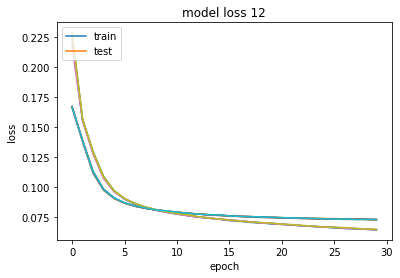

In [ ]:
import random

seeds = [1346, 76, 34, 46, 12]

for seed in seeds:
  tf.random.set_seed(seed)
  random.seed(seed)
  np.random.seed(seed)

  input = Input(shape =(10, 128))
  # Fully connected layer classifier
  x = Flatten()(input)
  x = Dense(units = 4096, activation ='relu')(x)
  x = Dropout(0.5)(x)
  x = Dense(units = 4096, activation ='relu')(x)
  # x = Dropout(0.5)(x)
  output = Dense(units = 20, activation ='sigmoid')(x)
  output = output[Y_mask]

  # creating the model
  model = Model (inputs=input, outputs = output)
  model.summary()

  LR = 1e-5 # Keep it small when transfer learning
  EPOCHS = 30
  loss_fn = tf.keras.losses.BinaryCrossentropy()

  model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
    loss=loss_fn, metrics = ['Recall', 'Precision'])
  
  earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
  mcp_save = ModelCheckpoint(f'mdl_wts_{seed}.hdf5', save_best_only=True, monitor='val_loss', mode='min')
  reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, verbose=1, epsilon=1e-4, mode='min')

  history = model.fit(x_train, epochs = EPOCHS, callbacks=[earlyStopping, mcp_save, reduce_lr_loss], validation_data = x_test)

  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title(f'model loss {seed}')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.savefig(f'history_{seed}.png')

In [ ]:
# import necessary layers  
from tensorflow.keras.layers import Input, Conv2D 
from tensorflow.keras.layers import MaxPool2D, Flatten, Dense, Dropout 
from tensorflow.keras import Model

input = Input(shape =(10, 128))
# Fully connected layer classifier
x = Flatten()(input)
x = Dense(units = 4096, activation ='relu')(x)
x = Dropout(0.5)(x)
x = Dense(units = 4096, activation ='relu')(x)
# x = Dropout(0.5)(x)
output = Dense(units = 20, activation ='sigmoid')(x)

# creating the model
model = Model (inputs=input, outputs =output)
model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 10, 128)]         0         
                                                                 
 flatten_7 (Flatten)         (None, 1280)              0         
                                                                 
 dense_21 (Dense)            (None, 4096)              5246976   
                                                                 
 dropout_10 (Dropout)        (None, 4096)              0         
                                                                 
 dense_22 (Dense)            (None, 4096)              16781312  
                                                                 
 dense_23 (Dense)            (None, 20)                81940     
                                                                 
Total params: 22,110,228
Trainable params: 22,110,228
Non-t

In [ ]:
LR = 1e-5 # Keep it small when transfer learning
EPOCHS = 30
loss_fn = tf.keras.losses.BinaryCrossentropy()

In [ ]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
  loss=loss_fn, metrics = ['Recall', 'Precision'])

In [ ]:
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save = ModelCheckpoint('mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, verbose=1, epsilon=1e-4, mode='min')

history = model.fit(x_train, epochs = EPOCHS, callbacks=[earlyStopping, mcp_save, reduce_lr_loss], validation_data = x_test)

Epoch 1/30
117/117 [==============================] - 3s 23ms/step - loss: 0.2215 - recall: 0.0137 - precision: 0.0456 - val_loss: 0.1663 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - lr: 1.0000e-05
Epoch 2/30
117/117 [==============================] - 2s 21ms/step - loss: 0.1559 - recall: 0.0048 - precision: 0.9844 - val_loss: 0.1382 - val_recall: 0.0268 - val_precision: 0.9918 - lr: 1.0000e-05
Epoch 3/30
117/117 [==============================] - 2s 20ms/step - loss: 0.1287 - recall: 0.0641 - precision: 0.9491 - val_loss: 0.1118 - val_recall: 0.1304 - val_precision: 0.9394 - lr: 1.0000e-05
Epoch 4/30
117/117 [==============================] - 2s 20ms/step - loss: 0.1075 - recall: 0.1962 - precision: 0.8780 - val_loss: 0.0973 - val_recall: 0.2590 - val_precision: 0.8616 - lr: 1.0000e-05
Epoch 5/30
117/117 [==============================] - 2s 20ms/step - loss: 0.0963 - recall: 0.3026 - precision: 0.8306 - val_loss: 0.0901 - val_recall: 0.3367 - val_precision: 0.8302 - lr: 1.0

In [ ]:
# list all data in history
print(history.history.keys())

dict_keys(['loss', 'recall', 'precision', 'val_loss', 'val_recall', 'val_precision', 'lr'])


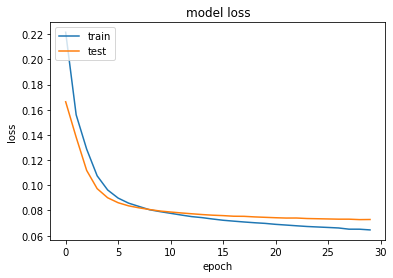

In [ ]:
# summarize history for accuracy
# plt.plot(history.history['recall'])
# plt.plot(history.history['precision'])
# plt.title('train precision-recall')
# plt.ylabel('precision')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
from keras.models import load_model

for seed in seeds:
  model = load_model(f'mdl_wts_{seed}.hdf5')
  y_pred = model.predict(x_test, batch_size = 1)
  y_pred1 = np.where(y_pred >= 0.5, 1, 0)
  print(classification_report(Y_test_labels, y_pred1))

40/40 [==============================] - 0s 6ms/step
              precision    recall  f1-score   support

           0       0.03      0.02      0.02       115
           1       0.01      0.01      0.01       140
           2       0.00      0.00      0.00       134
           3       0.09      0.04      0.06       226
           4       0.00      0.00      0.00       137
           5       0.06      0.05      0.06       297
           6       0.05      0.04      0.04       278
           7       0.02      0.01      0.01       175
           8       0.09      0.08      0.08       286
           9       0.02      0.01      0.01       211
          10       0.06      0.05      0.05       193
          11       0.10      0.03      0.05       121
          12       0.07      0.07      0.07       285
          13       0.05      0.05      0.05       305
          14       0.06      0.06      0.06       268
          15       0.03      0.02      0.02       228
          16       0.04     

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


40/40 [==============================] - 0s 6ms/step
              precision    recall  f1-score   support

           0       0.02      0.01      0.01       115
           1       0.02      0.01      0.02       140
           2       0.02      0.01      0.01       134
           3       0.09      0.05      0.06       226
           4       0.03      0.01      0.01       137
           5       0.07      0.05      0.06       297
           6       0.04      0.03      0.04       278
           7       0.05      0.03      0.04       175
           8       0.06      0.06      0.06       286
           9       0.06      0.03      0.04       211
          10       0.04      0.04      0.04       193
          11       0.02      0.01      0.01       121
          12       0.08      0.07      0.07       285
          13       0.04      0.04      0.04       305
          14       0.06      0.06      0.06       268
          15       0.04      0.02      0.03       228
          16       0.05     

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


40/40 [==============================] - 0s 6ms/step
              precision    recall  f1-score   support

           0       0.05      0.03      0.04       115
           1       0.04      0.03      0.03       140
           2       0.04      0.01      0.02       134
           3       0.01      0.00      0.01       226
           4       0.02      0.01      0.01       137
           5       0.07      0.05      0.06       297
           6       0.08      0.05      0.06       278
           7       0.02      0.01      0.01       175
           8       0.06      0.06      0.06       286
           9       0.04      0.03      0.03       211
          10       0.06      0.05      0.05       193
          11       0.03      0.01      0.01       121
          12       0.07      0.06      0.07       285
          13       0.08      0.07      0.07       305
          14       0.06      0.06      0.06       268
          15       0.06      0.04      0.04       228
          16       0.06     

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


40/40 [==============================] - 0s 5ms/step
              precision    recall  f1-score   support

           0       0.02      0.01      0.01       115
           1       0.01      0.01      0.01       140
           2       0.08      0.04      0.05       134
           3       0.03      0.01      0.02       226
           4       0.03      0.01      0.01       137
           5       0.06      0.05      0.06       297
           6       0.06      0.04      0.05       278
           7       0.05      0.03      0.03       175
           8       0.05      0.05      0.05       286
           9       0.05      0.03      0.04       211
          10       0.03      0.02      0.02       193
          11       0.10      0.03      0.05       121
          12       0.06      0.06      0.06       285
          13       0.06      0.05      0.05       305
          14       0.07      0.06      0.06       268
          15       0.05      0.03      0.04       228
          16       0.05     

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


40/40 [==============================] - 0s 6ms/step
              precision    recall  f1-score   support

           0       0.04      0.02      0.02       115
           1       0.06      0.04      0.04       140
           2       0.02      0.01      0.01       134
           3       0.05      0.03      0.04       226
           4       0.00      0.00      0.00       137
           5       0.06      0.05      0.05       297
           6       0.07      0.05      0.06       278
           7       0.05      0.03      0.04       175
           8       0.08      0.07      0.08       286
           9       0.06      0.03      0.04       211
          10       0.05      0.04      0.04       193
          11       0.02      0.01      0.01       121
          12       0.05      0.05      0.05       285
          13       0.08      0.08      0.08       305
          14       0.08      0.07      0.07       268
          15       0.05      0.03      0.04       228
          16       0.07     

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
y_pred = model.predict(x_test, batch_size = 1)
print(y_pred[0])
y_pred1 = np.where(y_pred >= 0.5, 1, 0)
print(y_pred1[0])

40/40 [==============================] - 0s 6ms/step
[2.1384990e-01 1.1609243e-03 1.4079579e-04 1.9858375e-02 8.4768385e-03
 1.1870984e-03 7.2388037e-04 3.7915925e-03 1.0523508e-02 9.1048109e-04
 9.0123899e-04 1.2783759e-02 1.3230937e-03 2.6681878e-02 9.0120435e-03
 3.5972991e-03 5.7203528e-03 2.4728877e-03 2.4128115e-02 6.7566023e-03]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [ ]:
print(multilabel_confusion_matrix(Y_test_labels, y_pred1))

In [ ]:
print(classification_report(Y_test_labels, y_pred1))

              precision    recall  f1-score   support

           0       0.02      0.01      0.01       115
           1       0.06      0.04      0.05       140
           2       0.04      0.01      0.02       134
           3       0.05      0.03      0.03       226
           4       0.00      0.00      0.00       137
           5       0.07      0.06      0.06       297
           6       0.06      0.04      0.05       278
           7       0.01      0.01      0.01       175
           8       0.06      0.05      0.06       286
           9       0.04      0.02      0.03       211
          10       0.04      0.04      0.04       193
          11       0.02      0.01      0.01       121
          12       0.07      0.06      0.06       285
          13       0.07      0.07      0.07       305
          14       0.10      0.09      0.09       268
          15       0.03      0.02      0.02       228
          16       0.08      0.05      0.06       318
          17       0.04    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
